## CNN Neural Network (Manual) For Cancerous and Non-Cancerous Cell Classification

In [4]:
# minimal imports necessary for our manual implementation of CNN
import numpy as np
import pandas as pd
import cv2

## Preprocessing Data

In [5]:
# Sources:
# Source - https://stackoverflow.com/a
# Posted by Usama Aleem
# Retrieved 2025-11-26, License - CC BY-SA 4.0
# Used for saving images

# https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c
# used to understand best image preprocessing practices
import os, sys
import matplotlib.pyplot as plt

'''
Converting images in the directory to .npy format for usability in CNN model.
We first load the image with cv2, grayscale it, then resize the image to a 
(256, 256) shape. We then normalize the number in a range of [0,1], and we 
apply a Gaussian blur to smooth the images. We then append this array to the
x_train data to be converted to a npy file.
'''

def preprocess_images(chosen_dir: str):
    path = '../data/cancer_dataset/lung_colon_image_set/'
    path = path+chosen_dir
    dirs = os.listdir( path )
    dirs.sort()
    for item in dirs:
        image = cv2.imread(path+item)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = cv2.resize(gray_image, (128, 128))
        # create the directory where the data will be stored
        dest_dir = os.path.join('smaller_cnn_data', chosen_dir)
        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, gray_image)

# do not run these, files already created
# preprocess_images('colon_image_sets/colon_aca/')
# preprocess_images('colon_image_sets/colon_n/')
# preprocess_images('lung_image_sets/lung_aca/')
# preprocess_images('lung_image_sets/lung_n/')
# preprocess_images('lung_image_sets/lung_scc/')



In [6]:
# Not recommended to use - npy files too large

# Sources:
# Source - https://stackoverflow.com/a
# Posted by Usama Aleem
# Retrieved 2025-11-26, License - CC BY-SA 4.0
# Used for learning to save images


# '''
# Convert our compress data to npy images
# '''

# def convert_to_npy(chosen_dir: str, filename: str):
#     path = 'reduced_cnn_data/'
#     path = path+chosen_dir
#     dirs = os.listdir( path )
#     dirs.sort()
#     x_train = []
#     for item in dirs:
#         image = cv2.imread(path+item)
#         img_array = np.array(image)
#         x_train.append(img_array)

#     # create the directory where the data will be stored
#     dest_dir = os.path.join('reduced_cnn_data/', 'npy/')
#     os.makedirs(dest_dir, exist_ok=True)
#     out_path = os.path.join(dest_dir, filename)
#     np.save(out_path, x_train)

# convert_to_npy('colon_image_sets/colon_aca/', 'colon_aca.npy')
# convert_to_npy('colon_image_sets/colon_n/', 'colon_n.npy')
# convert_to_npy('lung_image_sets/lung_aca/', 'lung_aca.npy')
# convert_to_npy('lung_image_sets/lung_n/', 'lung_n.npy')
# convert_to_npy('lung_image_sets/lung_scc/', 'lung_scc.npy')

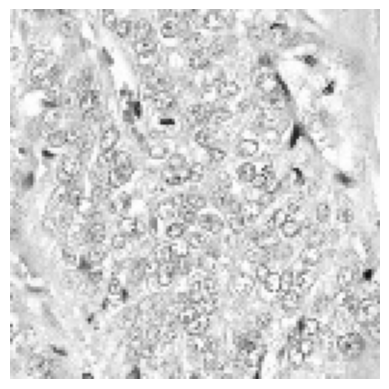

In [7]:
# Ensure images are properly printed out
grey_image = cv2.imread('smaller_cnn_data/colon_image_sets/colon_aca/colonca1.jpeg')
plt.imshow(grey_image)
plt.axis('off') 
plt.show()

In [8]:
# split the testing, validation, and training data
# read the data then split based on 
import math
import random

def split_data(subdir: str, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    path = os.path.join('smaller_cnn_data/', subdir)
    dirs = os.listdir( path )
    dirs.sort()
    i = 0
    random.shuffle(dirs)
    img_count = len(dirs)
    train_count = math.floor(img_count * train_ratio)
    val_count = train_count + math.floor(img_count * val_ratio)
    for item in dirs:
        image = cv2.imread(os.path.join(path, item))
        if image is None:
            print("Couldn't read:", item)
            continue
        dest_subdir = os.path.basename(os.path.normpath(path))
        if i < train_count:
            dest_dir = os.path.join('model_train_val_test/train/', dest_subdir)
        elif i < val_count:
            dest_dir = os.path.join('model_train_val_test/val/', dest_subdir)
        else:
            dest_dir = os.path.join('model_train_val_test/test/', dest_subdir)

        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)
        i = i + 1

# split_data('colon_image_sets/colon_aca/')
# split_data('colon_image_sets/colon_n/')
# split_data('lung_image_sets/lung_aca/')
# split_data('lung_image_sets/lung_n/')
# split_data('lung_image_sets/lung_scc/')

## Construct the CNN Architecture

Let's define our relevant CNN architectures

In [ ]:
'''
This defines a forward pass for the cnn layer for square images.
We receive a kernel and filter the image using the kernel.
kernel: the kernel we are using for convolution
image: the np array representing the image
pad: represents desried padding
stride: represents the stride amount
'''
def cnn_forward_pass(kernel: np.array, image: np.array, pad=0, stride=1):
    # pad the images with zeros
    if pad > 0:
        image = np.pad(image, pad, 'constant', constant_values=0)
    
    # checking if the stride given is valid (square kernels only)
    k, _ = kernel.shape
    p, _ = image.shape
    if (p-k) % stride != 0:
        print('Invalid stride, using a stride of 1')
        stride = 1

    # now perform the forward pass
    q = (p-k) // stride + 1
    feature_map = np.zeros((q, q))

    for m in range(q):
        for n in range(q):
            w = image[n*stride:n*stride+k, m*stride:m*stride+k]
            feature_map[m, n] = np.sum(w * kernel)
    return feature_map

'''
This defines a max pooling function after a CNN layer
feature_map: the resulting feaure map from the CNN layer
pool_size: size of the pool matrix
stride: stride amount
'''
def max_pool(feature_map: np.array, pool_size: int, stride=1):
    f, _ = feature_map.shape
    # checking if the stride given is valid (square kernels only)
    if (f - pool_size) % stride != 0:
        print('Invalid stride, using a stride of 1')
        stride = 1

    q = (f - pool_size) // stride + 1
    pooled_map = np.zeros((q, q))

    # to max pool, get the maximum number in the pool
    for m in range(q):
        for n in range(q):
            w = feature_map[n*stride:n*stride+f, m*stride:m*stride+f]
            feature_map[m, n] = np.max(w)
    return pooled_map

def cnn_backprop():
    return ''



Define MLP architecure

In [ ]:
def dense_layer():
    return ''

def output_layer():
    return ''

'''
Not sure if needed I think cnn backprop covers this
'''
def dense_backprop():
    return ''


Define our activation functions and their derivatives

In [ ]:
def sigmoid():
    return ''    

def dv_sigmoid():
    return ''

def softmax():
    return ''

def dv_softmax():
    return ''

def relu():
    return ''

def dv_relu():
    return ''

Define our loss functions and their derivatives

In [ ]:
def mle():
    return ''

def dv_mle():
    return ''

def log_loss():
    return ''

def dv_log_loss():
    return ''

def bin_crossentropy():
    return ''

def dv_bin_crossentropy():
    return ''

def cat_crossentropy():
    return ''

def dv_cat_crossentropy():
    return ''

## Construct the CNN Training Model

Create training for our model: One for Binary classification, and one for Multiclass classification